Mounting the Drive to load the Dataset


In [1]:
from google.colab import drive
drive.mount('/content/drive')
#include the path in which the data is stored
positive_proteins_dir = "/content/drive/MyDrive/utils/positive.txt"
#include path where positive proteins are present
negative_proteins_dir = "/content/drive/MyDrive/utils/negative.txt"
#include path where negative proteins are present

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing necessary libraries

In [2]:
import random
import numpy as np  
import torch 
import torch.nn as nn
import torch.nn.functional as F
import time 
import matplotlib.pyplot as plt

Helper functions necessary for converting .txt file to processible data

In [3]:

def average_sequence_length(data):
  sum =0
  for i in range(len(data)):
    sum += len(data[i][1])
  return (sum//len(data))

def add_amino_acids(protein, avg):
    n = len(protein)
    x = avg - n
    protein2 = protein + x*str('A')
    return protein2

def remove_amino_acids(protein,avg):
    n = len(protein)
    x = n - avg
    protein2 = protein[x//2:x//2+avg]
    return protein2

def augment_protein_sequence(data):
    avg = 390
    for i in range (len(data)):
        if (len(data[i][1])>avg):
          data[i][1] = remove_amino_acids(data[i][1],avg)
        else:
          data[i][1] = add_amino_acids(data[i][1],avg)
    return data 

def sequence_extraction(data_dir,protein_category):
    f = open(data_dir)
    lines = f.read() 
    lines = lines.split('>')
    out = [[0 for x in range(3)] for y in range(len(lines))]
    for i in range(len(lines)):
      line= lines[i].split(' ')
      accesion_code = line[0]
      sequence = line[-1].split(']')[-1].replace('\n','')
      out[i][0] = str(accesion_code)
      out[i][1] = str(sequence).replace('Precursor','')
      out[i][1] = out[i][1].replace('C887.02','')
      if (protein_category=='positive'):
          out[i][2]=1
      else :
          out[i][2]=0
    return out[1:]

protein_set ={
    'A':0,
    'C':1,
    'D':2,
    'E':3,
    'F':4,
    'G':5,
    'H':6,
    'I':7,
    'K':8,
    'L':9,
    'M':10,
    'N':11,
    'P':12,
    'Q':13,
    'R':14,
    'S':15,
    'T':16,
    'V':17,
    'W':18,
    'Y':19
}
def get_process_data(protein_data):
  random_sequence = protein_data[0][1]
  protein_size = len(random_sequence)
  data_size = len(protein_data)
  inputs = -1*np.ones((data_size,protein_size,20))
  labels = np.zeros((data_size,1))
  for i in range(data_size):
    protein_sequence = protein_data[i][1]
    for j in range (len(protein_sequence)):
      amino_acid = protein_sequence[j]
      if (amino_acid=='B' or amino_acid=='J' or  amino_acid=='O' or amino_acid=='U' or amino_acid=='X' or amino_acid=='Z'  ):
        amino_acid ='A'
      k = protein_set[amino_acid]
      inputs[i][j][k] = 390
    labels[i][0]=protein_data[i][2]
  inputs = np.reshape(inputs, [data_size,len(protein_data[0][1])*20])
  labels = np.reshape(labels, [data_size,1])
  inputs = torch.from_numpy(inputs)
  labels = torch.from_numpy(labels)
  inputs = inputs.type(torch.FloatTensor)
  labels = labels.type(torch.FloatTensor)
  return inputs, labels 

def get_data(protein_dataset):
  dataset = augment_protein_sequence(protein_dataset)
  training_set = dataset[0:5000]
  val_set = dataset[5000:5370]
  test_set = dataset[5370:]
  training_inputs, training_labels = get_process_data(training_set)
  val_inputs, val_labels = get_process_data(val_set)
  test_inputs, test_labels = get_process_data(test_set)
  return training_inputs, training_labels, val_inputs, val_labels, test_inputs, test_labels

def getlength(data):
    sequence_length= []
    for i in range(len(data)):
        sequence_length.append(len(data[i][1]))
    return np.array(sequence_length)
# print(dataset)

Data Visualization 


In [4]:
positive_proteins = sequence_extraction(positive_proteins_dir,'positive')
negative_proteins = sequence_extraction (negative_proteins_dir,'negative')
len_pos = getlength(positive_proteins)
len_neg = getlength(negative_proteins)
print("The number of positive classifiers in the dataset are :" + str(len(positive_proteins)))
print("The number of negative classifiers in the dataset are :" + str(len(negative_proteins)))
print(f"Average length of positive classifiers is: {average_sequence_length(positive_proteins)}")
print(f"Average length of negative classifiers is: {average_sequence_length(negative_proteins)}")

The number of positive classifiers in the dataset are :2870
The number of negative classifiers in the dataset are :76614
Average length of positive classifiers is: 226
Average length of negative classifiers is: 555


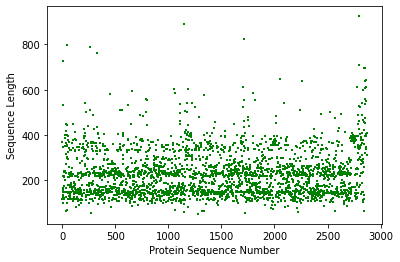

<Figure size 432x288 with 0 Axes>

In [5]:
plt.scatter(np.arange(0,len(len_pos),1), len_pos , color ='g', marker = '+', s= 6)
plt.xlabel("Protein Sequence Number")
plt.ylabel("Sequence Length")
plt.show()
plt.savefig('/content/drive/MyDrive/utils/positive_data_visualization.jpg')

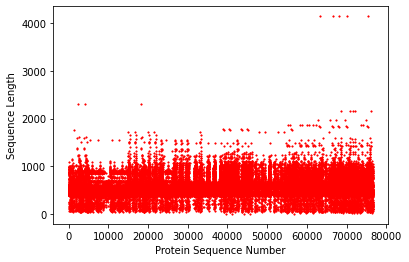

<Figure size 432x288 with 0 Axes>

In [6]:
plt.scatter(np.arange(0,len(len_neg),1), len_neg , color ='r', marker = 'X', s=1)
plt.xlabel("Protein Sequence Number")
plt.ylabel("Sequence Length")
plt.show()
plt.savefig('/content/drive/MyDrive/utils/negative_data_visualization.jpg')

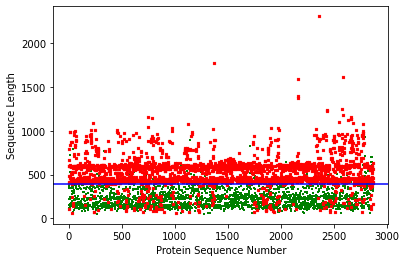

<Figure size 432x288 with 0 Axes>

In [7]:
protein_dataset = positive_proteins + negative_proteins[0:len(positive_proteins)]
plt.scatter(np.arange(0,len(len_pos),1), len_pos , color ='g', marker = '+', s= 6)
plt.scatter(np.arange(0,len(len_pos),1), len_neg[0:len(len_pos)] , color ='r', marker = 'X', s= 6)
# plt.plot(x390)
plt.axhline(y = 390, color ='b')
plt.xlabel("Protein Sequence Number")
plt.ylabel("Sequence Length")
plt.show()
plt.savefig('/content/drive/MyDrive/utils/positve_vs_negative_data_visualization.jpg')

Data Loading

In [8]:
augmented_sequences = augment_protein_sequence(protein_dataset)
random.shuffle(augmented_sequences)
training_inputs, training_labels, val_inputs, val_labels, test_inputs, test_labels = get_data(augmented_sequences)

Data Analysis is complete now. Proceeding towards model building

Model 1 - 5 Layers(7560-1000-400-100-20-1), Stochastic Gradient Descent, 50 epochs, learning rate = 0.0001, Momentum =0.9
loss used = Binary Cross Entropy

In [9]:
class nnModel1(nn.Module):
  def __init__(self):
    super (nnModel1,self).__init__()
    self.linear1 = nn.Linear(7800,1000)
    self.linear2 = nn.Linear(1000,400)
    self.linear3= nn.Linear(400,100)
    self.linear4 = nn.Linear(100,20)
    self.linear5 = nn.Linear(20,1)
    self.sigmoid = nn.Sigmoid()

  def forward(self,x):
    # print(type(x))
    x = self.linear1(x)
    x = self.linear2(x)
    x = self.linear3(x)
    x = self.linear4(x)
    x = self.linear5(x)
    x = self.sigmoid(x)
    return x

model1 = nnModel1()
Optimizer = torch.optim.SGD(model1.parameters(),lr =0.0001, momentum =0.9)
loss_fn_1 = nn.BCELoss()

Model1 Training


In [10]:
training_losses = []
val_accuracy = []
val_correct =[] 
val_losses=[]
max_accuracy = 0 
for epoch in range(50):
  Optimizer.zero_grad()
  training_predictions = model1(training_inputs)
  loss = loss_fn_1(training_predictions,training_labels)
  val_predictions = model1(val_inputs)
  val_loss = loss_fn_1(val_predictions, val_labels)
  val = torch.cat((val_predictions, val_labels),1)
  correct =0
  for i in range (val.shape[0]):
    if (abs(val[i][0]-val[i][1])<10e-5):
      correct =correct +1
  accuracy = float(correct/val.shape[0])
  val_correct.append(correct)
  val_accuracy.append(accuracy)
  training_losses.append(loss)
  val_losses.append(val_loss)
  print(f'Currently Running iteration number: {epoch+1}')
  print(f'Training Loss after {epoch+1} iterations: {loss}')
  print(f'Validation Loss after {epoch+1} iterations: {val_loss}')
  print(f'Correct Predictions after {epoch+1} iterations: {correct}')
  print(f'Validation Accuracy after {epoch+1} iterations: {accuracy*100}%')
  if (accuracy >max_accuracy):
    torch.save(model1.state_dict(),f"/content/drive/MyDrive/utils/Model1_data/Best accuracy parameters")
    max_accuracy = accuracy
  loss.backward()
  Optimizer.step()

Currently Running iteration number: 1
Training Loss after 1 iterations: 1.8886326551437378
Validation Loss after 1 iterations: 1.9178743362426758
Correct Predictions after 1 iterations: 15
Validation Accuracy after 1 iterations: 4.054054054054054%
Currently Running iteration number: 2
Training Loss after 2 iterations: 1.496050477027893
Validation Loss after 2 iterations: 1.463152289390564
Correct Predictions after 2 iterations: 48
Validation Accuracy after 2 iterations: 12.972972972972974%
Currently Running iteration number: 3
Training Loss after 3 iterations: 1.4877219200134277
Validation Loss after 3 iterations: 1.22480046749115
Correct Predictions after 3 iterations: 105
Validation Accuracy after 3 iterations: 28.37837837837838%
Currently Running iteration number: 4
Training Loss after 4 iterations: 1.3708962202072144
Validation Loss after 4 iterations: 1.1864675283432007
Correct Predictions after 4 iterations: 136
Validation Accuracy after 4 iterations: 36.75675675675676%
Currently

Loss and Accuracy Visualization

In [14]:
# for i in range (len(training_losses)):
#   training_losses[i] = training_losses[i].detach().numpy()
# for i in range (len(training_losses)):
#   val_losses[i] = val_losses[i].detach().numpy()
training_losses_np = np.array(training_losses)
val_losses_np = np.array(val_losses)
val_accuracy_np = np.array(val_accuracy)

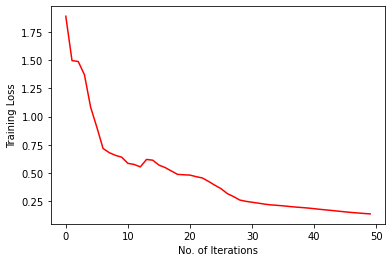

In [15]:
plt.plot(np.arange(0,50),training_losses_np, color='r')
plt.xlabel('No. of Iterations')
plt.ylabel('Training Loss')
plt.savefig('/content/drive/MyDrive/utils/Model1_data/ Iterations vs Loss Graph.jpg')
plt.show()

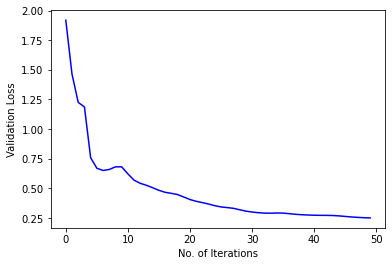

In [16]:
plt.plot(np.arange(0,50),val_losses_np, color='b')
plt.xlabel('No. of Iterations')
plt.ylabel('Validation Loss')
plt.savefig('/content/drive/MyDrive/utils/Model1_data/ Iterations vs Loss Graph.jpg')
plt.show()

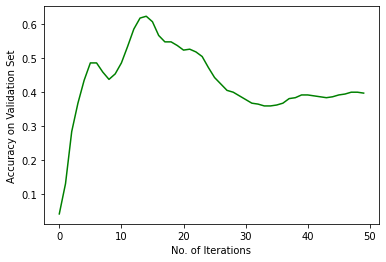

In [17]:
plt.plot(np.arange(0,50),val_accuracy_np, color='g')
plt.xlabel('No. of Iterations')
plt.ylabel('Accuracy on Validation Set')
plt.savefig('/content/drive/MyDrive/utils/Model1_data/ Iterations vs Loss Graph.jpg')
plt.show()

Model1 Testing 

In [18]:
with torch.no_grad():
  pred = model1(test_inputs)
  correct =0 
  test_predictions = torch.cat((pred,test_labels),1)
  for i in range (test_predictions .shape[0]):
    if (abs(test_predictions [i][0]-test_predictions [i][1])<10e-5):
      correct =correct +1
  print(f'Test Accuracy of Model 1 is: {correct*100/test_predictions .shape[0]}%')

Test Accuracy of Model 1 is: 37.027027027027025%
